# Method: LSTM 
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction of Small Dataset

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
train.data = train.data[:18000]
train.time = train.time[:18000]

In [6]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (18000, 40)
Test size: (90000, 40)


**Create test set**

In [7]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [8]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [9]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. LSTM Implementation

In [10]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2 = jax.random.split(rng, num = 2)
        dO = W_init(k1, (data_dim, h_dim))
        db = b_init(k2, (data_dim,))
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = sigmoid(forget_gate * c + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new), y
        (c_final, h_final), pred_traj = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), pred_traj[-1]
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = sigmoid(forget_gate * cell + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new, y), y
        
        _, pred_traj = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj
    
    return init_fun, process, forecast

In [11]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 50):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [12]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [113]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [114]:
nn_size = 100

In [115]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 0.52 | Train loss = 0.0308275 | Val loss =  17.7034435
Epoch 20: Time taken = 0.52 | Train loss = 0.0156744 | Val loss =  120.5700455
Epoch 30: Time taken = 0.59 | Train loss = 0.0098559 | Val loss =  222.4815979
Epoch 40: Time taken = 0.54 | Train loss = 0.0071474 | Val loss =  304.0574951
Epoch 50: Time taken = 0.52 | Train loss = 0.0056293 | Val loss =  355.6291504
Epoch 60: Time taken = 0.53 | Train loss = 0.0046190 | Val loss =  472.6367798
Epoch 70: Time taken = 0.51 | Train loss = 0.0040854 | Val loss =  410.8063660
Epoch 80: Time taken = 0.55 | Train loss = 0.0035556 | Val loss =  341.5445557
Epoch 90: Time taken = 0.52 | Train loss = 0.0032195 | Val loss =  292.2420654
Epoch 100: Time taken = 0.54 | Train loss = 0.0029320 | Val loss =  245.2976074
Epoch 110: Time taken = 0.53 | Train loss = 0.0027541 | Val loss =  160.5376587
Epoch 120: Time taken = 0.54 | Train loss = 0.0025179 | Val loss =  201.8982544
Epoch 130: Time taken = 0.5

In [118]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.55


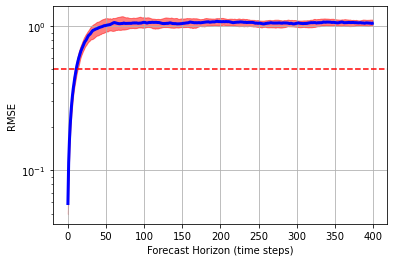

It takes around t = 0.11 for mean error to exceed 0.5


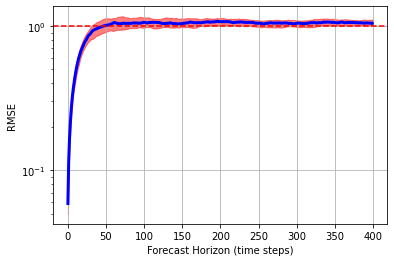

It takes around t = 0.47 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.729
Median NRMSE at t = 0.5: 1.008
Median NRMSE at t = 1: 1.058
Median NRMSE at t = 2: 1.071
Median NRMSE at t = 3: 1.042


In [119]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [120]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [121]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.68 | Train loss = 0.0378921 | Val loss =  1.5842434
Epoch 20: Time taken = 0.68 | Train loss = 0.0158812 | Val loss =  16.4007072
Epoch 30: Time taken = 0.69 | Train loss = 0.0079975 | Val loss =  97.5601425
Epoch 40: Time taken = 0.69 | Train loss = 0.0049062 | Val loss =  143.8173981
Epoch 50: Time taken = 0.69 | Train loss = 0.0033538 | Val loss =  121.7048264
Epoch 60: Time taken = 0.69 | Train loss = 0.0024821 | Val loss =  147.8316498
Epoch 70: Time taken = 0.69 | Train loss = 0.0019845 | Val loss =  97.5541992
Epoch 80: Time taken = 0.69 | Train loss = 0.0016585 | Val loss =  135.0928650
Epoch 90: Time taken = 0.69 | Train loss = 0.0014573 | Val loss =  209.4554291
Epoch 100: Time taken = 0.72 | Train loss = 0.0012721 | Val loss =  132.9041748
Epoch 110: Time taken = 0.69 | Train loss = 0.0012207 | Val loss =  169.4962311
Epoch 120: Time taken = 0.69 | Train loss = 0.0010871 | Val loss =  95.7424088
Epoch 130: Time taken = 0.69 | T

In [122]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.73


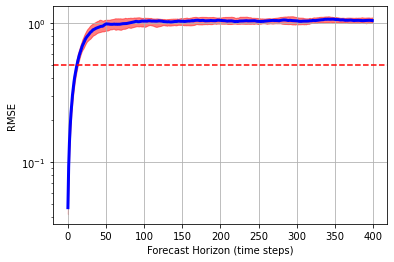

It takes around t = 0.12 for mean error to exceed 0.5


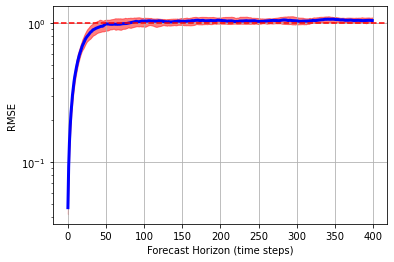

It takes around t = 0.81 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.704
Median NRMSE at t = 0.5: 0.983
Median NRMSE at t = 1: 1.030
Median NRMSE at t = 2: 1.041
Median NRMSE at t = 3: 1.035


In [123]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [124]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [125]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.76 | Train loss = 0.0373018 | Val loss =  1.3302225
Epoch 20: Time taken = 1.77 | Train loss = 0.0122667 | Val loss =  13.4870758
Epoch 30: Time taken = 1.77 | Train loss = 0.0054319 | Val loss =  13.0652046
Epoch 40: Time taken = 1.78 | Train loss = 0.0032738 | Val loss =  29.4268780
Epoch 50: Time taken = 1.78 | Train loss = 0.0023818 | Val loss =  18.4153004
Epoch 60: Time taken = 1.79 | Train loss = 0.0019702 | Val loss =  7.5485454
Epoch 70: Time taken = 1.79 | Train loss = 0.0015535 | Val loss =  9.6203728
Epoch 80: Time taken = 1.78 | Train loss = 0.0013879 | Val loss =  5.0489726
Epoch 90: Time taken = 1.80 | Train loss = 0.0013672 | Val loss =  6.4412780
Epoch 100: Time taken = 1.78 | Train loss = 0.0011459 | Val loss =  28.1804428
Epoch 110: Time taken = 1.79 | Train loss = 0.0010263 | Val loss =  7.8704877
Epoch 120: Time taken = 1.80 | Train loss = 0.0012095 | Val loss =  3.7490151
Epoch 130: Time taken = 1.79 | Train loss = 0

In [126]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 1.18


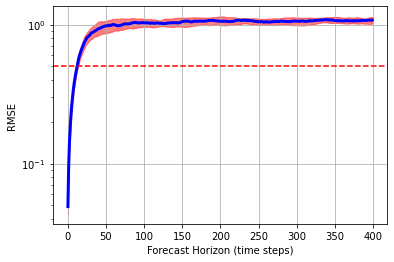

It takes around t = 0.12 for mean error to exceed 0.5


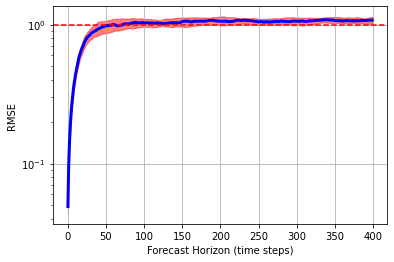

It takes around t = 0.59 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.705
Median NRMSE at t = 0.5: 0.981
Median NRMSE at t = 1: 1.032
Median NRMSE at t = 2: 1.058
Median NRMSE at t = 3: 1.059


In [127]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [128]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [129]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.35 | Train loss = 0.0496786 | Val loss =  1.1894203
Epoch 20: Time taken = 3.38 | Train loss = 0.0184985 | Val loss =  1.8675330
Epoch 30: Time taken = 3.36 | Train loss = 0.0072678 | Val loss =  6.8008318
Epoch 40: Time taken = 3.37 | Train loss = 0.0039503 | Val loss =  6.0593452
Epoch 50: Time taken = 3.37 | Train loss = 0.0029083 | Val loss =  4.5934677
Epoch 60: Time taken = 3.37 | Train loss = 0.0021192 | Val loss =  7.5450320
Epoch 70: Time taken = 3.38 | Train loss = 0.0019431 | Val loss =  20.9617538
Epoch 80: Time taken = 3.36 | Train loss = 0.0017079 | Val loss =  16.1862049
Epoch 90: Time taken = 3.37 | Train loss = 0.0013478 | Val loss =  1.9060085
Epoch 100: Time taken = 3.37 | Train loss = 0.0012423 | Val loss =  3.9116518
Epoch 110: Time taken = 3.37 | Train loss = 0.0010896 | Val loss =  2.1018269
Epoch 120: Time taken = 3.37 | Train loss = 0.0012145 | Val loss =  1.7453452
Epoch 130: Time taken = 3.38 | Train loss = 0.00

In [130]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 1.87


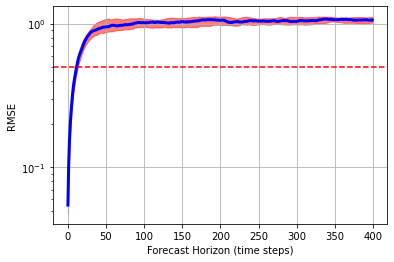

It takes around t = 0.12 for mean error to exceed 0.5


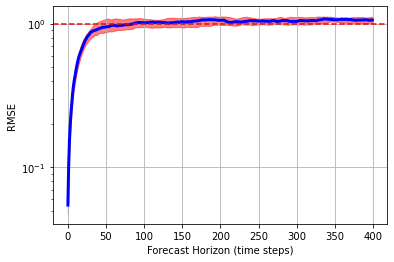

It takes around t = 0.87 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.708
Median NRMSE at t = 0.5: 0.950
Median NRMSE at t = 1: 1.015
Median NRMSE at t = 2: 1.056
Median NRMSE at t = 3: 1.037


In [131]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 500
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [132]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [133]:
L_forecast_train = 4; L_past = 1

In [134]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.32 | Train loss = 0.0125232 | Val loss =  5.8771863
Epoch 20: Time taken = 0.30 | Train loss = 0.0058364 | Val loss =  36.6709290
Epoch 30: Time taken = 0.32 | Train loss = 0.0035224 | Val loss =  64.0491714
Epoch 40: Time taken = 0.30 | Train loss = 0.0024362 | Val loss =  127.9175568
Epoch 50: Time taken = 0.32 | Train loss = 0.0018243 | Val loss =  112.3260651
Epoch 60: Time taken = 0.30 | Train loss = 0.0014284 | Val loss =  112.2300720
Epoch 70: Time taken = 0.29 | Train loss = 0.0011482 | Val loss =  127.9186325
Epoch 80: Time taken = 0.32 | Train loss = 0.0009373 | Val loss =  128.5227356
Epoch 90: Time taken = 0.30 | Train loss = 0.0007893 | Val loss =  123.2853165
Epoch 100: Time taken = 0.30 | Train loss = 0.0006694 | Val loss =  122.9398117
Epoch 110: Time taken = 0.31 | Train loss = 0.0005857 | Val loss =  120.2920837
Epoch 120: Time taken = 0.39 | Train loss = 0.0005071 | Val loss =  122.7549286
Epoch 130: Time taken = 0.33 |

In [135]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 0.69


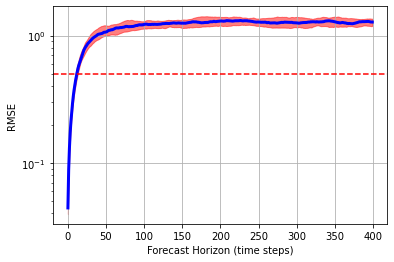

It takes around t = 0.12 for mean error to exceed 0.5


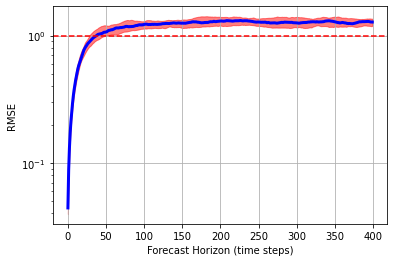

It takes around t = 0.38 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.740
Median NRMSE at t = 0.5: 1.066
Median NRMSE at t = 1: 1.223
Median NRMSE at t = 2: 1.302
Median NRMSE at t = 3: 1.257


In [136]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [137]:
L_forecast_train = 4; L_past = 4

In [138]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.46 | Train loss = 0.0111022 | Val loss =  11.0896826
Epoch 20: Time taken = 0.46 | Train loss = 0.0044918 | Val loss =  150.7478943
Epoch 30: Time taken = 0.46 | Train loss = 0.0024925 | Val loss =  266.8734436
Epoch 40: Time taken = 0.46 | Train loss = 0.0016811 | Val loss =  287.0701599
Epoch 50: Time taken = 0.46 | Train loss = 0.0012640 | Val loss =  302.5778809
Epoch 60: Time taken = 0.47 | Train loss = 0.0010304 | Val loss =  285.2843933
Epoch 70: Time taken = 0.46 | Train loss = 0.0008735 | Val loss =  289.5616150
Epoch 80: Time taken = 0.46 | Train loss = 0.0007815 | Val loss =  248.2512054
Epoch 90: Time taken = 0.46 | Train loss = 0.0007064 | Val loss =  273.2019348
Epoch 100: Time taken = 0.46 | Train loss = 0.0006619 | Val loss =  261.8021851
Epoch 110: Time taken = 0.47 | Train loss = 0.0006249 | Val loss =  241.0222015
Epoch 120: Time taken = 0.46 | Train loss = 0.0005807 | Val loss =  262.9251404
Epoch 130: Time taken = 0.4

In [139]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 0.77


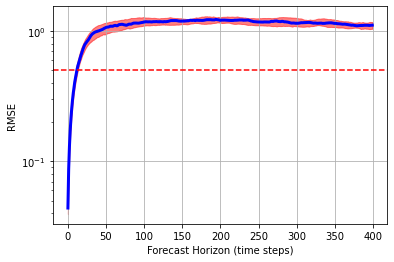

It takes around t = 0.12 for mean error to exceed 0.5


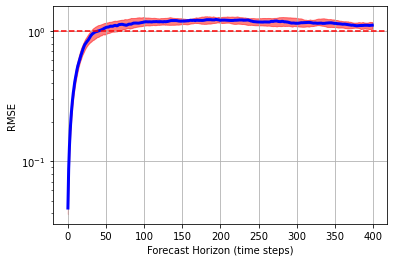

It takes around t = 0.39 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.736
Median NRMSE at t = 0.5: 1.069
Median NRMSE at t = 1: 1.180
Median NRMSE at t = 2: 1.212
Median NRMSE at t = 3: 1.153


In [140]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [141]:
L_forecast_train = 4; L_past = 8

In [142]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.68 | Train loss = 0.0111029 | Val loss =  14.1678600
Epoch 20: Time taken = 0.68 | Train loss = 0.0044816 | Val loss =  107.9663162
Epoch 30: Time taken = 0.68 | Train loss = 0.0025008 | Val loss =  249.2997131
Epoch 40: Time taken = 0.68 | Train loss = 0.0016808 | Val loss =  303.4699402
Epoch 50: Time taken = 0.68 | Train loss = 0.0012689 | Val loss =  270.4622803
Epoch 60: Time taken = 0.68 | Train loss = 0.0010359 | Val loss =  275.1830444
Epoch 70: Time taken = 0.69 | Train loss = 0.0008976 | Val loss =  214.9951935
Epoch 80: Time taken = 0.68 | Train loss = 0.0007874 | Val loss =  235.0280762
Epoch 90: Time taken = 0.68 | Train loss = 0.0007333 | Val loss =  196.6096802
Epoch 100: Time taken = 0.68 | Train loss = 0.0006915 | Val loss =  202.9675446
Epoch 110: Time taken = 0.68 | Train loss = 0.0006693 | Val loss =  207.0285950
Epoch 120: Time taken = 0.68 | Train loss = 0.0006192 | Val loss =  151.2461090
Epoch 130: Time taken = 0.6

In [143]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 0.75


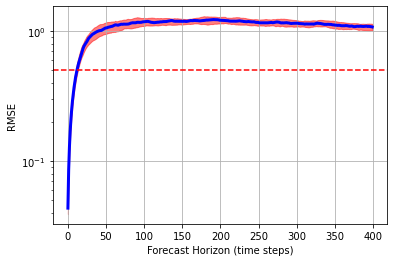

It takes around t = 0.12 for mean error to exceed 0.5


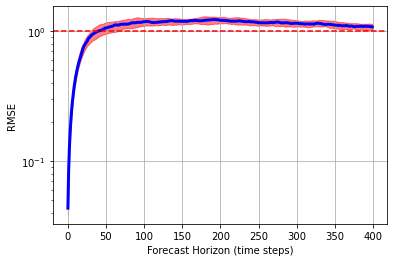

It takes around t = 0.40 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.741
Median NRMSE at t = 0.5: 1.059
Median NRMSE at t = 1: 1.183
Median NRMSE at t = 2: 1.214
Median NRMSE at t = 3: 1.152


In [144]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [145]:
L_forecast_train = 8; L_past = 1

In [146]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.52 | Train loss = 0.0384767 | Val loss =  1.4987462
Epoch 20: Time taken = 0.54 | Train loss = 0.0172640 | Val loss =  6.1435623
Epoch 30: Time taken = 0.52 | Train loss = 0.0093837 | Val loss =  24.7207680
Epoch 40: Time taken = 0.52 | Train loss = 0.0060318 | Val loss =  33.2283897
Epoch 50: Time taken = 0.52 | Train loss = 0.0042780 | Val loss =  39.8727074
Epoch 60: Time taken = 0.52 | Train loss = 0.0032989 | Val loss =  38.8232574
Epoch 70: Time taken = 0.52 | Train loss = 0.0026977 | Val loss =  38.7825203
Epoch 80: Time taken = 0.52 | Train loss = 0.0022187 | Val loss =  41.7068367
Epoch 90: Time taken = 0.52 | Train loss = 0.0019121 | Val loss =  36.3887291
Epoch 100: Time taken = 0.52 | Train loss = 0.0017027 | Val loss =  36.8965797
Epoch 110: Time taken = 0.52 | Train loss = 0.0015148 | Val loss =  38.7665482
Epoch 120: Time taken = 0.52 | Train loss = 0.0013535 | Val loss =  28.8408852
Epoch 130: Time taken = 0.52 | Train los

In [147]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 0.76


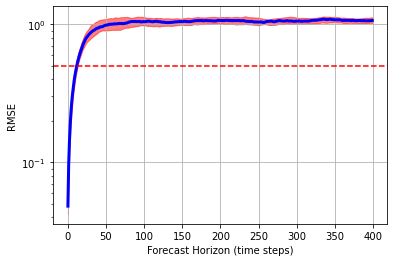

It takes around t = 0.12 for mean error to exceed 0.5


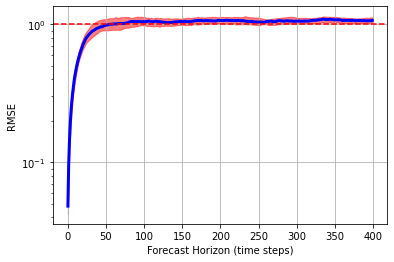

It takes around t = 0.55 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.717
Median NRMSE at t = 0.5: 0.985
Median NRMSE at t = 1: 1.044
Median NRMSE at t = 2: 1.067
Median NRMSE at t = 3: 1.053


In [148]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [149]:
L_forecast_train = 8; L_past = 4

In [150]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.71 | Train loss = 0.0378921 | Val loss =  1.5842434
Epoch 20: Time taken = 0.69 | Train loss = 0.0158812 | Val loss =  16.4007072
Epoch 30: Time taken = 0.71 | Train loss = 0.0079975 | Val loss =  97.5601425
Epoch 40: Time taken = 0.81 | Train loss = 0.0049062 | Val loss =  143.8173981
Epoch 50: Time taken = 0.69 | Train loss = 0.0033538 | Val loss =  121.7048264
Epoch 60: Time taken = 0.69 | Train loss = 0.0024821 | Val loss =  147.8316498
Epoch 70: Time taken = 0.77 | Train loss = 0.0019845 | Val loss =  97.5541992
Epoch 80: Time taken = 0.69 | Train loss = 0.0016585 | Val loss =  135.0928650
Epoch 90: Time taken = 0.71 | Train loss = 0.0014573 | Val loss =  209.4554291
Epoch 100: Time taken = 0.72 | Train loss = 0.0012721 | Val loss =  132.9041748
Epoch 110: Time taken = 0.70 | Train loss = 0.0012207 | Val loss =  169.4962311
Epoch 120: Time taken = 0.70 | Train loss = 0.0010871 | Val loss =  95.7424088
Epoch 130: Time taken = 0.70 | T

In [151]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_5_mu_preds.pkl")

Testing complete. Time taken: 0.72


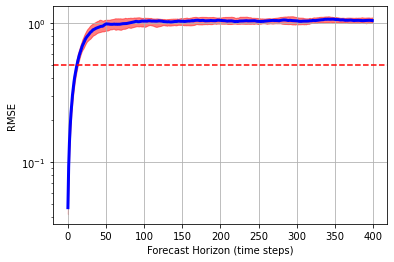

It takes around t = 0.12 for mean error to exceed 0.5


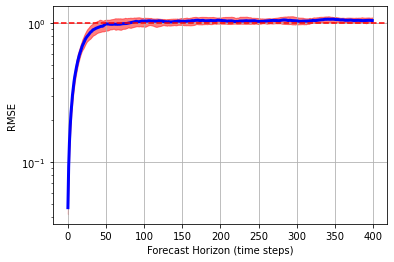

It takes around t = 0.81 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.704
Median NRMSE at t = 0.5: 0.983
Median NRMSE at t = 1: 1.030
Median NRMSE at t = 2: 1.041
Median NRMSE at t = 3: 1.035


In [152]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [153]:
L_forecast_train = 8; L_past = 8

In [154]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.92 | Train loss = 0.0379474 | Val loss =  1.7191585
Epoch 20: Time taken = 0.91 | Train loss = 0.0158848 | Val loss =  21.0282078
Epoch 30: Time taken = 0.92 | Train loss = 0.0079995 | Val loss =  79.7902145
Epoch 40: Time taken = 0.92 | Train loss = 0.0048942 | Val loss =  101.0820160
Epoch 50: Time taken = 0.92 | Train loss = 0.0033368 | Val loss =  116.9969711
Epoch 60: Time taken = 0.92 | Train loss = 0.0024682 | Val loss =  128.9050140
Epoch 70: Time taken = 0.91 | Train loss = 0.0020111 | Val loss =  119.8466034
Epoch 80: Time taken = 0.92 | Train loss = 0.0016541 | Val loss =  102.8609314
Epoch 90: Time taken = 0.92 | Train loss = 0.0014612 | Val loss =  123.9932404
Epoch 100: Time taken = 0.92 | Train loss = 0.0012870 | Val loss =  105.8938141
Epoch 110: Time taken = 0.92 | Train loss = 0.0012113 | Val loss =  102.1191788
Epoch 120: Time taken = 0.92 | Train loss = 0.0011499 | Val loss =  105.1476440
Epoch 130: Time taken = 0.92 |

In [155]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_6_mu_preds.pkl")

Testing complete. Time taken: 0.73


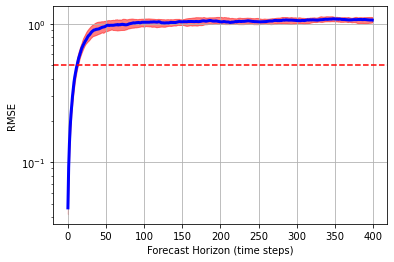

It takes around t = 0.12 for mean error to exceed 0.5


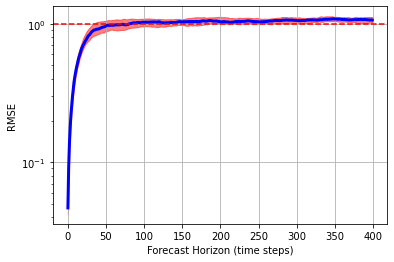

It takes around t = 0.81 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.701
Median NRMSE at t = 0.5: 0.966
Median NRMSE at t = 1: 1.028
Median NRMSE at t = 2: 1.035
Median NRMSE at t = 3: 1.057


In [156]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [157]:
L_forecast_train = 16; L_past = 1

In [158]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.98 | Train loss = 0.1400176 | Val loss =  1.0852313
Epoch 20: Time taken = 0.97 | Train loss = 0.0780228 | Val loss =  1.2655169
Epoch 30: Time taken = 0.97 | Train loss = 0.0395825 | Val loss =  2.2307885
EARLY STOPPING. Epoch 32: Train loss = 0.0348517 | Val loss =  3.4018872
Best Validation MSE: 0.9453192
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.97 | Train loss = 0.0534088 | Val loss =  1.6129878
Epoch 20: Time taken = 0.97 | Train loss = 0.0229858 | Val loss =  3.9667988
Epoch 30: Time taken = 0.97 | Train loss = 0.0134486 | Val loss =  7.0753889
Epoch 40: Time taken = 0.98 | Train loss = 0.0091715 | Val loss =  7.9039660
Epoch 50: Time taken = 0.97 | Train loss = 0.0067668 | Val loss =  6.5285516
Epoch 60: Time taken = 0.97 | Train loss = 0.0053430 | Val loss =  7.5298357
Epoch 70: Time taken = 0.97 | Train loss = 0.0045957 | Val loss =  7.9127545
Epoch 80: Time taken = 0.97 | Train loss = 0.0039034 | Val loss =  6.7588482
E

In [159]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_7_mu_preds.pkl")

Testing complete. Time taken: 0.69


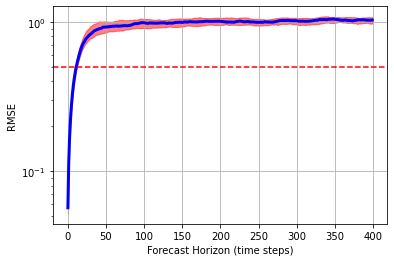

It takes around t = 0.11 for mean error to exceed 0.5


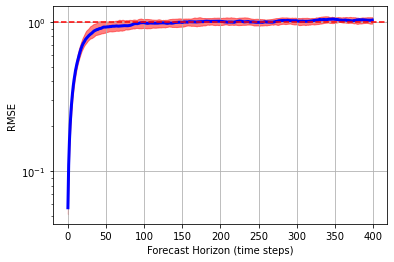

It takes around t = 1.58 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.716
Median NRMSE at t = 0.5: 0.923
Median NRMSE at t = 1: 0.988
Median NRMSE at t = 2: 1.008
Median NRMSE at t = 3: 1.018


In [160]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [161]:
L_forecast_train = 16; L_past = 4

In [162]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.15 | Train loss = 0.1394983 | Val loss =  1.0551946
Epoch 20: Time taken = 1.16 | Train loss = 0.0776030 | Val loss =  1.3551618
Epoch 30: Time taken = 1.15 | Train loss = 0.0380505 | Val loss =  3.2934759
EARLY STOPPING. Epoch 32: Train loss = 0.0333562 | Val loss =  5.5541492
Best Validation MSE: 0.9231991
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 1.18 | Train loss = 0.0504341 | Val loss =  2.0844817
Epoch 20: Time taken = 1.15 | Train loss = 0.0207099 | Val loss =  6.1148205
Epoch 30: Time taken = 1.16 | Train loss = 0.0118893 | Val loss =  17.6463337
Epoch 40: Time taken = 1.16 | Train loss = 0.0077280 | Val loss =  27.8693161
Epoch 50: Time taken = 1.15 | Train loss = 0.0055872 | Val loss =  32.9488487
Epoch 60: Time taken = 1.16 | Train loss = 0.0042129 | Val loss =  34.2180519
Epoch 70: Time taken = 1.16 | Train loss = 0.0035427 | Val loss =  30.6233349
Epoch 80: Time taken = 1.16 | Train loss = 0.0029973 | Val loss =  19.010

In [163]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_8_mu_preds.pkl")

Testing complete. Time taken: 0.81


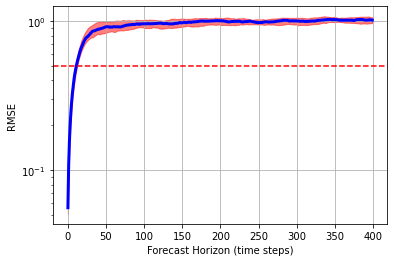

It takes around t = 0.11 for mean error to exceed 0.5


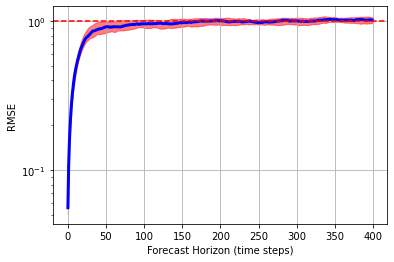

It takes around t = 1.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.709
Median NRMSE at t = 0.5: 0.915
Median NRMSE at t = 1: 0.958
Median NRMSE at t = 2: 1.006
Median NRMSE at t = 3: 1.001


In [164]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [165]:
L_forecast_train = 16; L_past = 8

In [166]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.38 | Train loss = 0.1389652 | Val loss =  1.0709456
Epoch 20: Time taken = 1.69 | Train loss = 0.0767969 | Val loss =  1.3832073
Epoch 30: Time taken = 1.38 | Train loss = 0.0379276 | Val loss =  6.2477818
EARLY STOPPING. Epoch 32: Train loss = 0.0330739 | Val loss =  9.1035976
Best Validation MSE: 0.9217119
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 1.37 | Train loss = 0.0509167 | Val loss =  1.5166504
Epoch 20: Time taken = 1.37 | Train loss = 0.0207726 | Val loss =  8.5842543
Epoch 30: Time taken = 1.38 | Train loss = 0.0118184 | Val loss =  19.8019867
Epoch 40: Time taken = 1.37 | Train loss = 0.0077096 | Val loss =  22.4964504
Epoch 50: Time taken = 1.37 | Train loss = 0.0056069 | Val loss =  28.6381760
Epoch 60: Time taken = 1.37 | Train loss = 0.0045083 | Val loss =  22.5974827
Epoch 70: Time taken = 1.37 | Train loss = 0.0036690 | Val loss =  19.6594048
Epoch 80: Time taken = 1.37 | Train loss = 0.0030967 | Val loss =  37.693

In [167]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_9_mu_preds.pkl")

Testing complete. Time taken: 0.68


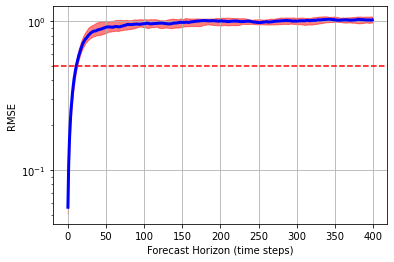

It takes around t = 0.11 for mean error to exceed 0.5


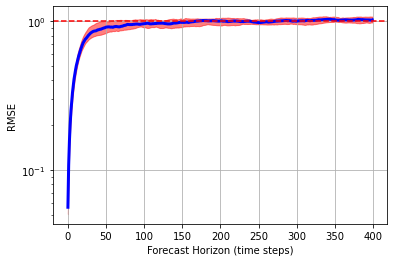

It takes around t = 1.69 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.715
Median NRMSE at t = 0.5: 0.912
Median NRMSE at t = 1: 0.960
Median NRMSE at t = 2: 1.004
Median NRMSE at t = 3: 1.001


In [168]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 500  
L_forecast_train = 4  
L_past = 4

In [13]:
nn_size = 500
L_forecast_train = 8
L_past = 4

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [400, 200, 200, 200]  # Number of epochs for each learning rate

In [14]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)

Backpropogation start

Epoch 10: Time taken = 0.72 | Train loss = 0.0378372 | Val loss =  1.5478739
Epoch 20: Time taken = 0.77 | Train loss = 0.0158373 | Val loss =  14.4200678
Epoch 30: Time taken = 0.70 | Train loss = 0.0079894 | Val loss =  92.7686768
Epoch 40: Time taken = 0.74 | Train loss = 0.0049018 | Val loss =  136.3399200
Epoch 50: Time taken = 0.71 | Train loss = 0.0033636 | Val loss =  124.7563553
Epoch 60: Time taken = 0.71 | Train loss = 0.0024978 | Val loss =  132.6923676
Epoch 70: Time taken = 0.71 | Train loss = 0.0019968 | Val loss =  121.6426010
Epoch 80: Time taken = 0.70 | Train loss = 0.0016612 | Val loss =  110.3023758
Epoch 90: Time taken = 0.71 | Train loss = 0.0014591 | Val loss =  153.6241302
Epoch 100: Time taken = 0.72 | Train loss = 0.0012840 | Val loss =  112.7043457
Epoch 110: Time taken = 0.71 | Train loss = 0.0012223 | Val loss =  141.4452972
Epoch 120: Time taken = 0.72 | Train loss = 0.0010899 | Val loss =  91.4237366
Epoch 130: Time taken = 0.72 | 

In [15]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.02


In [16]:
save_obj(params, "results/lstm", "best_params.pkl")
save_obj(mean_pred, "results/lstm", "best_mu_preds.pkl")

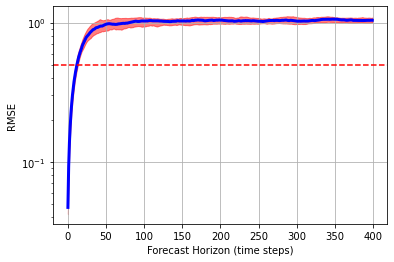

It takes around t = 0.12 for mean error to exceed 0.5


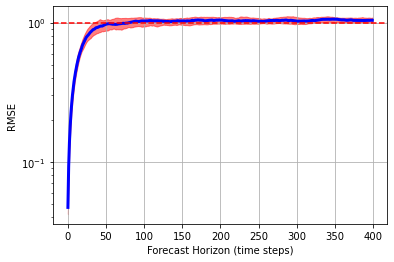

It takes around t = 0.81 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.706
Median NRMSE at t = 0.5: 0.975
Median NRMSE at t = 1: 1.026
Median NRMSE at t = 2: 1.042
Median NRMSE at t = 3: 1.026


In [17]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [13]:
nn_size = 500
_, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [14]:
params = load_obj("results/lstm/best_params.pkl")

In [15]:
mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
save_obj(mean_pred, "results", "lstm_pred.pkl")

Testing complete. Time taken: 1.98


In [10]:
mean_pred = load_obj("results/lstm_pred.pkl")

In [11]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

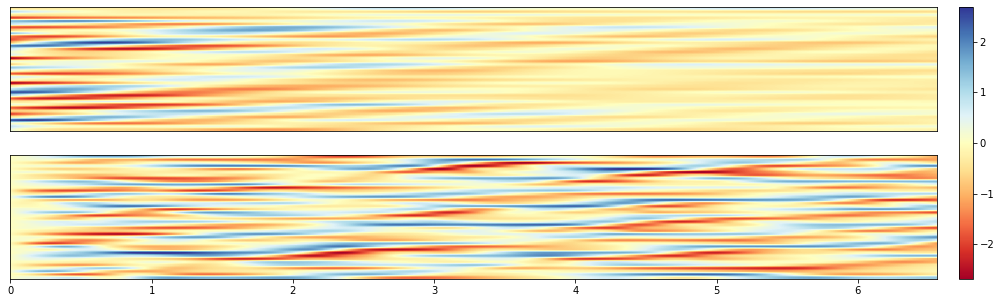

In [12]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_small_lstm", pred_only = True)

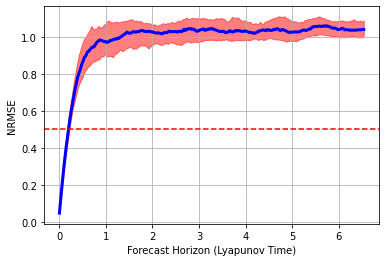

It takes around 0.20 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.858
Median NRMSE at 1.0 Lyapunov Time: 0.973
Median NRMSE at 2.0 Lyapunov Time: 1.028
Median NRMSE at 5.0 Lyapunov Time: 1.025


In [22]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "lorenz_small_lstm_ph")
print()
res_single.get_loss()